In [13]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})


import nfp
print(f"nfp version: {nfp.__version__}")
from preprocess_inputs_redox import preprocessor
preprocessor.from_json('inputs/preprocessor.json')

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

%matplotlib inline

nfp version: 0.2.0


In [14]:
os.getcwd()

'/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc'

In [15]:
!nvidia-smi

Thu Feb 18 21:51:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 30%   42C    P2    35W / 250W |   1699MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
model_name = "20210216_redox_lc"
inputs_dir = f"inputs/{model_name}"
outputs_dir = f"outputs/{model_name}"
num_new_train = len(np.load(f'{inputs_dir}/split_redox.npz', allow_pickle=True)['train_new'])
# split the 3K new calculations into groups evenly spaced by log
num_train_list = np.logspace(2, np.log10(num_new_train), num=6, dtype=int)
# make sure the last entry includes all training data
num_train_list[-1] = num_new_train
num_train_list

array([ 100,  199,  399,  799, 1599, 3198])

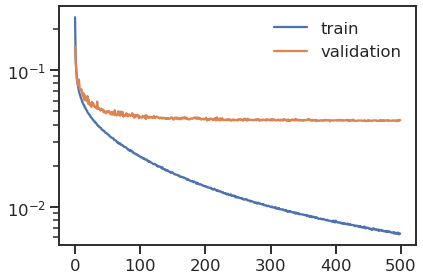

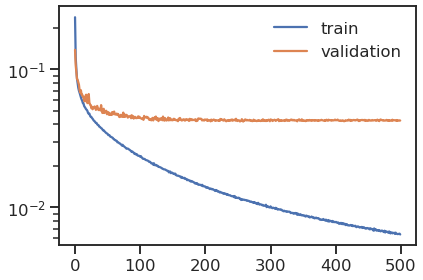

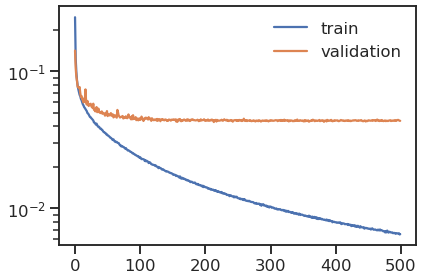

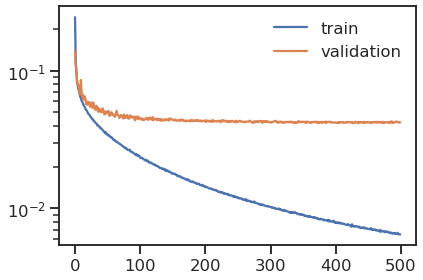

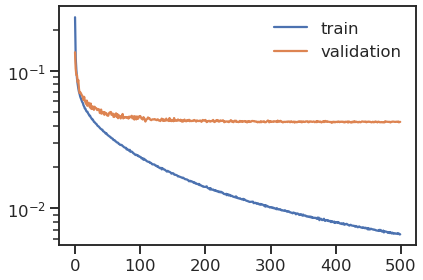

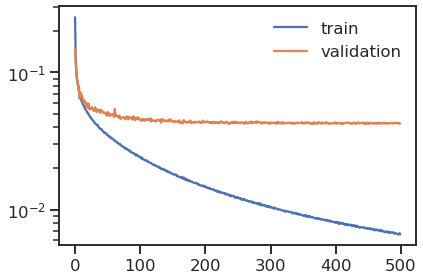

In [17]:
for num in num_train_list:
#     fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))
    fig, ax = plt.subplots()
    log = pd.read_csv(f'{outputs_dir}/n_{num}/log.csv', error_bad_lines=False).set_index('epoch')

    ax.plot(log['loss'], label='train')
    ax.plot(log['val_loss'], label='validation')
    ax.set_yscale('log')
    ax.legend()

    plt.tight_layout()

In [18]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [19]:
redox_df.notna().sum(0)

smiles               94743
ionization energy    51599
electron affinity    83627
oxidized_s2           2355
reduced_s2             216
dtype: int64

In [20]:
# Load the "new test" set which is the 500 of the most recent DFT calculations we left out 
data = np.load(f'{inputs_dir}/split_redox.npz', allow_pickle=True)
test = data['test_new']

In [21]:
redox_new_calcs = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/20210211_fixed_rl_redox_data.csv')
redox_new_calcs.head()

,ionization energy,electron affinity,err_smiles,smiles
0,0.913684,-0.292055,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1,C#CC1=C(C(C)C)C(C2CC2)=C([O])CC1
1,1.066037,-0.326042,C#C[CH]C(C)=C(C(=O)O)C(C)(C)C,C#C[CH]/C(C)=C(\C(=O)O)C(C)(C)C
2,-0.883864,-0.382259,CC(=C(C=C([O])O)C(C)(C)C)C(C)(C)C,C/C(=C(/C=C(\[O])O)C(C)(C)C)C(C)(C)C
3,0.844432,-0.547755,CC(=C(C(O)=C[O])C(C)(C)C)C(C)(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)(C)C
4,0.843045,-0.576871,CC(=C(C(O)=C[O])C(C)(C)C)C(C)C,C/C(=C(C(/O)=C/[O])\C(C)(C)C)C(C)C


In [22]:
redox_new_calcs.notna().sum(0)

ionization energy    2637
electron affinity    3665
err_smiles           3723
smiles               3723
dtype: int64

In [23]:
redox_valid = redox_new_calcs[redox_new_calcs.smiles.isin(data['test_new'])]

In [24]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [25]:
# store the predictions for each of the points along the learning curve
learning_curve_pred = {}
for num_train in num_train_list:
    model_file = f'{outputs_dir}/n_{num_train}/best_model.hdf5'
    print(f"Loading {model_file}")
    model = tf.keras.models.load_model(
        model_file,
        custom_objects={**nfp.custom_objects,
                        **{'EdgeUpdate': EdgeUpdate,
                           'NodeUpdate': NodeUpdate,
                           'GlobalUpdate': GlobalUpdate}})

    new_model = tf.keras.Model(model.inputs[:3], model.outputs)
    predicted_redox = new_model.predict(test_dataset, verbose=1)
    learning_curve_pred[num_train] = predicted_redox

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


4/4 [==============================] - 0s 67ms/step


/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n100.jpg


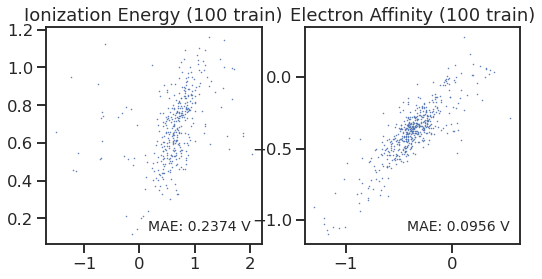

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n199.jpg


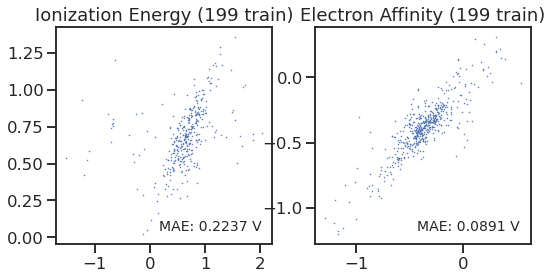

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n399.jpg


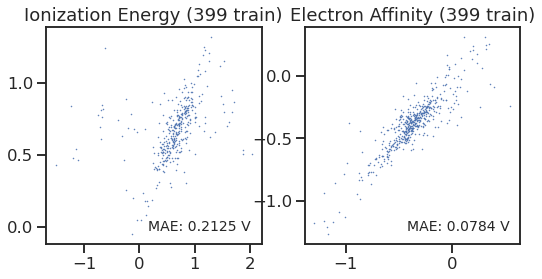

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n799.jpg


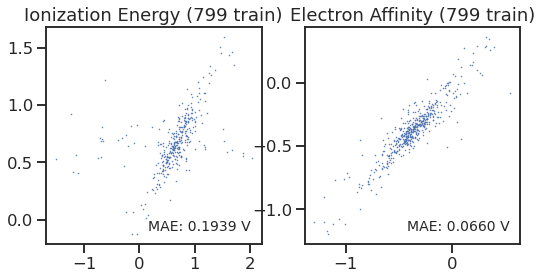

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n1599.jpg


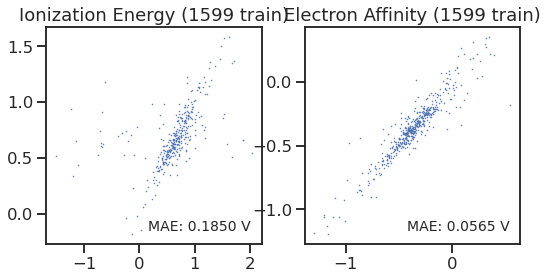

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-16-redox-scatter-n3198.jpg


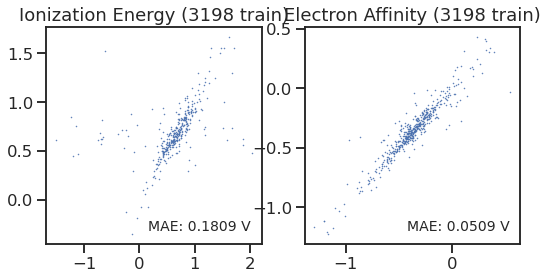

In [32]:
redox_ie_mae_list = []
redox_ea_mae_list = []
for num_train in num_train_list:
    pred_redox = learning_curve_pred[num_train]

    # compute the Mean Average Error
    redox_ie_mae = (redox_valid['ionization energy'] - pred_redox[:, 0]).abs().mean()
    redox_ea_mae = (redox_valid['electron affinity'] - pred_redox[:, 1]).abs().mean()
    # and store for later
    redox_ie_mae_list.append(redox_ie_mae)
    redox_ea_mae_list.append(redox_ea_mae)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
    axs[0].plot(redox_valid['ionization energy'], pred_redox[:, 0], '.', ms=1)
    axs[1].plot(redox_valid['electron affinity'], pred_redox[:, 1], '.', ms=1)

    axs[0].text(.95, .05, f"MAE: {redox_ie_mae:.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
    axs[1].text(.95, .05, f"MAE: {redox_ea_mae:.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

    axs[0].set_title(f'Ionization Energy ({num_train} train)')
    axs[1].set_title(f'Electron Affinity ({num_train} train)')

    out_file = f'{outputs_dir}/2021-02-16-redox-scatter-n{num_train}.jpg'
    print(os.path.abspath(out_file))
    fig.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.show()

/home/jlaw/projects/arpa-e/alfabet/spin_gnn_fork/20210208_redox_rerun_new_calcs_lc/outputs/20210216_redox_lc/2021-02-18-redox-lc-MAE.jpg


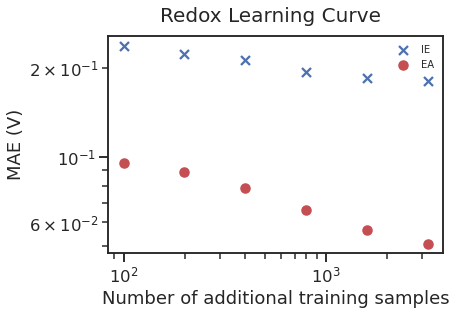

In [34]:
# now plot the learning curve of the MAE
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(num_train_list, redox_ie_mae_list, c='b', marker="x", label='IE')
ax1.scatter(num_train_list, redox_ea_mae_list, c='r', marker="o", label='EA')

fig.suptitle('Redox Learning Curve', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.xlabel('Number of additional training samples')
plt.ylabel('MAE (V)')
plt.legend(fontsize=10)
out_file = f'{outputs_dir}/2021-02-18-redox-lc-MAE.jpg'
print(os.path.abspath(out_file))
fig.savefig(out_file, dpi=300, bbox_inches='tight')
plt.show()